## EECS 731 Project 6

### Step 0: Import relevant packages

In [22]:
# Import libraries necessary for this project
import os
#import sys
import time
import sklearn
#import networkx as nx
import numpy  as np
import pandas as pd
from scipy import stats
import seaborn as sns; sns.set()
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from pandas import compat

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import mixture

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

compat.PY3 = True
print ("-----------------------------------------------------------------------")
print('The scikit-learn version is {}.'.format(sklearn.__version__))

-----------------------------------------------------------------------
The scikit-learn version is 0.20.3.


### Step 1: Pre requisite functions

#### This function load the data from the given path and finename

In [2]:
#Function to load the data
def loadData(path,filename):
    try:
             files = os.listdir(path)
             for f in files:
                 if f == filename:
                     data = pd.read_csv(os.path.join(path,f))
                     return data
            
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This function derives the shape of the dataset and returns the feature and target columns

In [3]:
#Function to explore the data
def exploreData(data):
    try:
           #Total number of records                                  
           rows = data.shape[0]
           cols = data.shape[1]    
          
           # Print the results
           print ("-----------------------------------------------------------------------")
           print ("Total number of records: {}".format(rows))
           print ("Total number of features: {}".format(cols))
           print ("-----------------------------------------------------------------------")
           
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This function computes the percentage of missing values per each column in the given dataset

In [4]:
def missingValues(data):
    try:
           # Total missing values
           mis_val = data.isnull().sum()
         
           # Percentage of missing values
           mis_val_percent = 100 * mis_val / len(data)
           
           # Make a table with the results
           mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
           
           # Rename the columns
           mis_val_table_ren_columns = mis_val_table.rename(
           columns = {0 : 'Missing Values', 1 : '% of Total Values'})
           mis_val_table_ren_columns.head(4 )
           # Sort the table by percentage of missing descending
           misVal = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                   '% of Total Values', ascending=False).round(1)
                     
           return misVal, mis_val_table_ren_columns

    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method scale the numerical features and label encoding for categorical features 

In [5]:
def transformData(df):
    try:    
        #Get the list of columns having negative columns from describe
        nc = []
        for i in df.columns:
            if df[i].min() < 0:
                nc.append(i)
         
        target = df[' shares']
        features_transform = pd.DataFrame(data = df)
        features_transform = features_transform.drop(columns=[' shares'], axis=1)
        
        #Add constant value to make the negative values as positive.
        for i in nc:
            minv = features_transform[i].min()
            minv = minv * -1
            features_transform[i] = features_transform[i] + minv

        #Get the list of columns that are skew
        sc = []
        for i in features_transform.columns:
            if df[i].max() > 1:
                sc.append(i)
                
        #Scale the data to reduce the skewness 
#        features_transform[sc] = features_transform[sc].apply(lambda x: np.log(x + 1))
        scaler = MinMaxScaler() # default=(0, 1)
        features_transform[sc] = scaler.fit_transform(features_transform[sc])
        
        ind = np.where(target < 1400)
        target.iloc[ind] = 1
        
        ind = np.where(target >=1400)
        target.iloc[ind] = 0

        return features_transform, target
        
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)


#### This method splits data in to training and test data

In [6]:
#split the data in to train and test data
def splitData(features,target,testsize):
    try:
        # Split the 'features' and 'income' data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target, 
                                                    test_size = testsize, 
                                                    random_state = 1)

        # Show the results of the split
        print ("Features training set has {} samples.".format(X_train.shape[0]))
        print ("Features testing set has {} samples.".format(X_test.shape[0]))
        print ("Target training set has {} samples.".format(y_train.shape[0]))
        print ("Target testing set has {} samples.".format(y_test.shape[0]))
        print ("-----------------------------------------------------------------------")
        return X_train, X_test, y_train, y_test
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements Multinomial Bayesian classifier

In [7]:
def multinomialnb(X_train, X_test, y_train, y_test):
    try:
        #logic
        clf = MultinomialNB()
        params = {}

        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
        
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
        results['f_train']   = fbeta_score(y_train, clf_predict_train, average='micro', beta=1)
        results['f_test']    = fbeta_score(y_test, clf_predict_test, average='micro', beta=1.5)
        
        return results,clf_fit_train      
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements SVM Classifier

In [8]:
def svmClassifier(X_train, X_test, y_train, y_test):
    try:
        #Decision tree classifier
        #learner = DecisionTreeClassifier(criterion=method, max_depth=depth, random_state=1)
        clf = svm.SVC(random_state=0)
        params = {'gamma':[0.001]}
        #params = {'criterion':['gini','entropy'], 'max_depth' : np.array([6,7,8])}
         
        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
         
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
        
        return results,clf_fit_train      
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements Ramdom Forest classifier

In [9]:
def randomForest(X_train, X_test, y_train, y_test):
    try:
        clf = RandomForestClassifier(max_depth=2, random_state=0)
        #params = {}
        params = {'criterion':['gini','entropy'], 'max_depth' : np.array([6,7,8]),'random_state': [0]}
         
        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
         
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
         
        return results,clf_fit_train, 
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implement Principal component analyis 

In [17]:
def pca(features,dim):
    try:
        #logic
        pca = PCA(n_components=dim)
        pca.fit(features)
        reduced_dim = pca.transform(features)
        
#        from pics import pca_results
#        _ = pca_results(features, pca)
        
        dlist = [];
        for i in range(dim):
            s = "D" + str(i)
            dlist.append(s)
        pca_comp = pd.DataFrame(pca.components_,columns=features.columns,index = dlist)
        pca_comp.transpose().to_csv('test.csv')
        return reduced_dim, pca_comp
    
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implement Gaussian mixture clustering

In [18]:
def gclus(reduced_data,ic):
    try:
        cluster =  mixture.GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=ic, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None).fit(reduced_data)
        
        pred = cluster.predict(reduced_data)
        
        centers = np.empty(shape=(cluster.n_components, reduced_data.shape[1]))
        for i in range(cluster.n_components):
            density = stats.multivariate_normal(cov=cluster.covariances_[i], mean=cluster.means_[i]).logpdf(reduced_data)
            centers[i, :] = reduced_data[np.argmax(density)]
        score = metrics.silhouette_score(reduced_data, pred, metric='euclidean')
        
        return cluster, centers,score
        
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### Load and check the data

In [10]:
path = r'C:\Users\pmspr\Documents\HS\MS\Sem 3\EECS 731\Project\Repos\News Popularity\Git\EECS-731-Project-7\Data'
filename = "OnlineNewsPopularity.csv"
data = loadData(path,filename)

#Check the missing values
misVal, mis_val_table_ren_columns = missingValues(data)
display(mis_val_table_ren_columns.head(20))

,Missing Values,% of Total Values
url,0,0.0
timedelta,0,0.0
n_tokens_title,0,0.0
n_tokens_content,0,0.0
n_unique_tokens,0,0.0
n_non_stop_words,0,0.0
n_non_stop_unique_tokens,0,0.0
num_hrefs,0,0.0
num_self_hrefs,0,0.0
num_imgs,0,0.0


### Understand the features

In [11]:
des = data.describe().transpose()
display(des)

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
n_unique_tokens,39644.0,0.548216,3.520708,0.00000,0.470870,0.539226,0.608696,701.000000
n_non_stop_words,39644.0,0.996469,5.231231,0.00000,1.000000,1.000000,1.000000,1042.000000
n_non_stop_unique_tokens,39644.0,0.689175,3.264816,0.00000,0.625739,0.690476,0.754630,650.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000


### Feature Engineering

In [12]:
#Remove rows with missing target values
col = ['url']
data = data.drop(columns=col, axis=1)

exploreData(data)

-----------------------------------------------------------------------
Total number of records: 39644
Total number of features: 60
-----------------------------------------------------------------------


#### Explore and Tansform the data

In [13]:
data_raw = data
features, target = transformData(data_raw)
display(features.describe().transpose())

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,0.479295,0.296215,0.0,0.215768,0.457815,0.738589,1.000000
n_tokens_title,39644.0,0.399940,0.100668,0.0,0.333333,0.380952,0.476190,1.000000
n_tokens_content,39644.0,0.064493,0.055594,0.0,0.029030,0.048265,0.084494,1.000000
n_unique_tokens,39644.0,0.000782,0.005022,0.0,0.000672,0.000769,0.000868,1.000000
n_non_stop_words,39644.0,0.000956,0.005020,0.0,0.000960,0.000960,0.000960,1.000000
n_non_stop_unique_tokens,39644.0,0.001060,0.005023,0.0,0.000963,0.001062,0.001161,1.000000
num_hrefs,39644.0,0.035802,0.037276,0.0,0.013158,0.026316,0.046053,1.000000
num_self_hrefs,39644.0,0.028393,0.033234,0.0,0.008621,0.025862,0.034483,1.000000
num_imgs,39644.0,0.035501,0.064917,0.0,0.007812,0.007812,0.031250,1.000000
num_videos,39644.0,0.013735,0.045141,0.0,0.000000,0.000000,0.010989,1.000000


#### Split the data between training and test sizes

In [14]:
#Split the data 70% training and 30% test
X_train, X_test, y_train, y_test = splitData(features,target,0.3)

Features training set has 27750 samples.
Features testing set has 11894 samples.
Target training set has 27750 samples.
Target testing set has 11894 samples.
-----------------------------------------------------------------------


#### Implement the Multinomial bayesian classifier

In [35]:
#Multinomial naive bayesian classifer
results,learner = multinomialnb(X_train, X_test, y_train, y_test)

print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

Times for Training, Prediction: 0.07551, 0.00480
Accuracy for Training, Test sets: 0.62930, 0.63032
-----------------------------------------------------------------------


#### Implement SVM Classifier

In [39]:
#Implement Support Vector Machine Classifier
results,learner = svmClassifier(X_train, X_test, y_train, y_test)

print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

Times for Training, Prediction: 245.66576, 67.42515
Accuracy for Training, Test sets: 0.61542, 0.61308
-----------------------------------------------------------------------


#### Implement Random forest tree 

In [40]:
results,learner = randomForest(X_train, X_test, y_train, y_test)
featureImp = pd.DataFrame(columns=['feature','importance'])
featureImp['feature'] = features.columns
featureImp['importance'] = learner.feature_importances_
featureImp = featureImp.sort_values(by='importance')
display(featureImp)
print ("-----------------------------------------------------------------------")
print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

,feature,importance
4,n_non_stop_words,0.000000
30,weekday_is_monday,0.000394
31,weekday_is_tuesday,0.000398
32,weekday_is_wednesday,0.000411
34,weekday_is_friday,0.000511
33,weekday_is_thursday,0.000614
12,data_channel_is_lifestyle,0.000911
18,kw_min_min,0.002676
53,min_negative_polarity,0.002785
51,max_positive_polarity,0.003009


-----------------------------------------------------------------------
Times for Training, Prediction: 6.11491, 0.03302
Accuracy for Training, Test sets: 0.70404, 0.66050
-----------------------------------------------------------------------


#### Implement Principal component analysis

In [20]:
#Implement the PCA with 6 dimensions
dim = 6
reduced_f, pca_comp = pca(features,dim)

#### Implement Gaussian mixture clustering

-----------------------------------------------------------------------
silhouette score for GMM: 0.3677
Optimal number of components: 10.0000
number of centers: 10.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.5086
Optimal number of components: 20.0000
number of centers: 20.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.5000
Optimal number of components: 30.0000
number of centers: 30.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.4381
Optimal number of components: 40.0000
number of centers: 40.0000
-----------------------------------------------------------------------


Text(0.5,1,'Clustering scores')

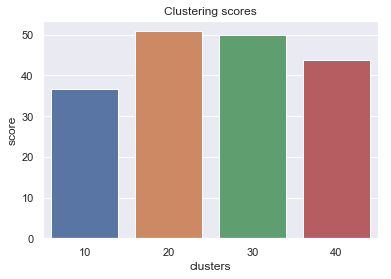

In [25]:
clus_df = pd.DataFrame(columns=['clusters','score'])
clist = [10,20,30,40]; slist = [];
for dim in clist:
    cluster, centers, score = gclus(reduced_f,dim)
    slist.append(score * 100)
    print ("-----------------------------------------------------------------------")
    print "silhouette score for GMM: {:.4f}".format(score)
    print "Optimal number of components: {:.4f}".format(cluster.n_components)
    print "number of centers: {:.4f}".format(len(centers))
    print ("-----------------------------------------------------------------------")

clus_df['clusters'] = clist
clus_df['score'] = slist

ax = sns.barplot(x="clusters", y="score", data=clus_df)
ax.set_title('Clustering scores')


In [ ]:
data.to_csv('test.csv',index=False)